In [2]:
pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 1.9 MB/s eta 0:00:31
    --------------------------------------- 1.0/56.8 MB 2.0 MB/s eta 0:00:28
    --------------------------------------- 1.3/56.8 MB 2.0 MB/s eta 0:00:29
   - -------------------------------------- 1.8/56.8 MB 1.9 MB/s eta 0:00:29
   - -------------------------------------- 1.8/56.8 MB 1.9 MB/s eta 0:00:29
   - -------------------------------------- 2.4/56.8 MB 1.6 MB/s eta 0:00:34
   - -------------------------------------- 2.6/56.8 MB 1.6 MB/s eta 0:00:34
   -- ------------------------------------- 3.1/56.8 MB 1.7 MB/s eta 0:00:33
   -- ------------------------------------- 3.4/56.8 MB 1.7 MB/s eta 0:00:32
   -- ------------------------------------- 3.7/56.8 MB 1.7 MB/s eta 0:00:32
   -- ------------------------------------- 4.2/56.8 MB 1.7 MB/s eta 0:00:32
   --- ------

In [1]:
# AdaBoost vs XGBoost on UCI Bank Marketing Dataset
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, roc_curve)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [8]:
# 1. Load dataset (UCI version)
df = pd.read_csv("C:/Users/user/Documents/data_science_bootcamp_challenges_project/advanced_ml_challenge/bank.csv")
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [10]:
# 2. Preprocessing
# Encode target (yes=1, no=0)
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

# One-hot encode categorical features
df = pd.get_dummies(df, drop_first=True)

# Split features and target
X = df.drop('deposit', axis=1)
y = df['deposit']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# 3. Model setup
ada_params = [
    {"n_estimators": 50, "learning_rate": 0.5, "max_depth": 1},
    {"n_estimators": 100, "learning_rate": 0.5, "max_depth": 2},
    {"n_estimators": 200, "learning_rate": 1.0, "max_depth": 1}
]

xgb_params = [
    {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 3},
    {"n_estimators": 200, "learning_rate": 0.1, "max_depth": 4},
    {"n_estimators": 300, "learning_rate": 0.05, "max_depth": 5}
]

def eval_model(model, X, y, name):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    metrics = {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
        "f1": f1_score(y, y_pred),
        "roc_auc": roc_auc_score(y, y_prob)
    }
    print(f"\n{name} Results:")
    print(classification_report(y, y_pred))
    return metrics
    

In [13]:
# 4. Train AdaBoost
best_ada, best_auc_ada = None, 0

for p in ada_params:
    base = DecisionTreeClassifier(max_depth=p["max_depth"], random_state=42)
    
    #use 'estimator' instead of 'base_estimator'
    model = AdaBoostClassifier(
        estimator=base,
        n_estimators=p["n_estimators"],
        learning_rate=p["learning_rate"],
        random_state=42
    )
    
    start = time.time()
    model.fit(X_train_scaled, y_train)
    duration = time.time() - start
    
    auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    print(f"AdaBoost {p} AUC={auc:.4f}, time={duration:.2f}s")
    
    if auc > best_auc_ada:
        best_auc_ada, best_ada = auc, model

AdaBoost {'n_estimators': 50, 'learning_rate': 0.5, 'max_depth': 1} AUC=0.8858, time=0.49s
AdaBoost {'n_estimators': 100, 'learning_rate': 0.5, 'max_depth': 2} AUC=0.9115, time=1.39s
AdaBoost {'n_estimators': 200, 'learning_rate': 1.0, 'max_depth': 1} AUC=0.9063, time=1.82s


In [15]:
# 5. Train XGBoost
best_xgb, best_auc_xgb = None, 0

for p in xgb_params:
    model = XGBClassifier(
        n_estimators=p["n_estimators"],
        learning_rate=p["learning_rate"],
        max_depth=p["max_depth"],
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
    
    start = time.time()
    model.fit(X_train_scaled, y_train)
    duration = time.time() - start
    
    auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    print(f"XGBoost {p} AUC={auc:.4f}, time={duration:.2f}s")
    
    if auc > best_auc_xgb:
        best_auc_xgb, best_xgb = auc, model


XGBoost {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3} AUC=0.9230, time=0.10s
XGBoost {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 4} AUC=0.9318, time=0.15s
XGBoost {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 5} AUC=0.9320, time=0.31s


In [16]:
# 6. Evaluation
ada_metrics = eval_model(best_ada, X_test_scaled, y_test, "AdaBoost")
xgb_metrics = eval_model(best_xgb, X_test_scaled, y_test, "XGBoost")



AdaBoost Results:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1175
           1       0.83      0.84      0.83      1058

    accuracy                           0.84      2233
   macro avg       0.84      0.84      0.84      2233
weighted avg       0.84      0.84      0.84      2233


XGBoost Results:
              precision    recall  f1-score   support

           0       0.89      0.84      0.87      1175
           1       0.84      0.89      0.86      1058

    accuracy                           0.86      2233
   macro avg       0.86      0.86      0.86      2233
weighted avg       0.87      0.86      0.86      2233



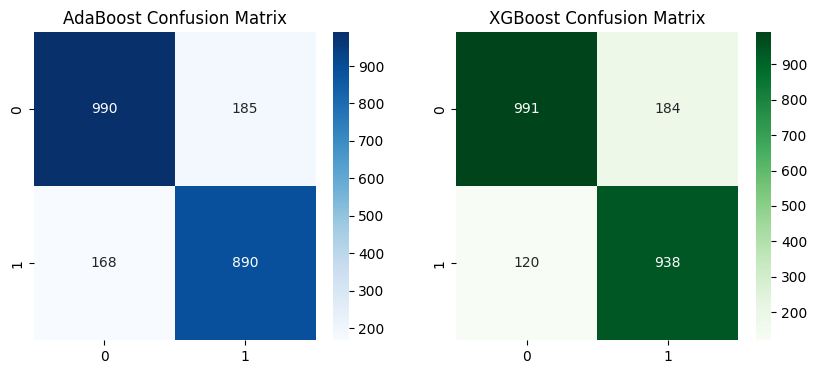

In [17]:
# 7. Visualization
# Confusion Matrices
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, best_ada.predict(X_test_scaled)), annot=True, fmt="d", cmap="Blues")
plt.title("AdaBoost Confusion Matrix")
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, best_xgb.predict(X_test_scaled)), annot=True, fmt="d", cmap="Greens")
plt.title("XGBoost Confusion Matrix")
plt.show()

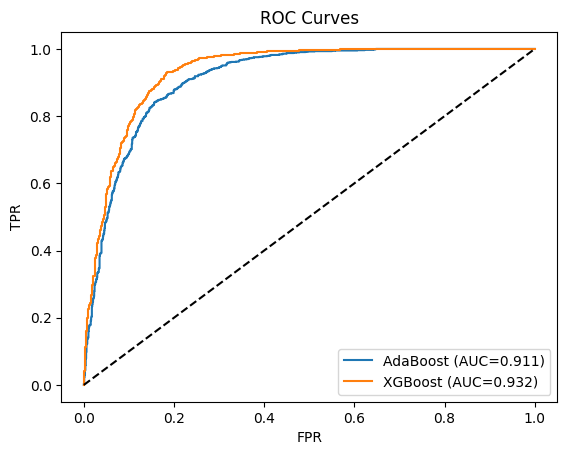

In [18]:
# ROC Curves
fpr_a, tpr_a, _ = roc_curve(y_test, best_ada.predict_proba(X_test_scaled)[:,1])
fpr_x, tpr_x, _ = roc_curve(y_test, best_xgb.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr_a, tpr_a, label=f"AdaBoost (AUC={best_auc_ada:.3f})")
plt.plot(fpr_x, tpr_x, label=f"XGBoost (AUC={best_auc_xgb:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.legend(); plt.title("ROC Curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

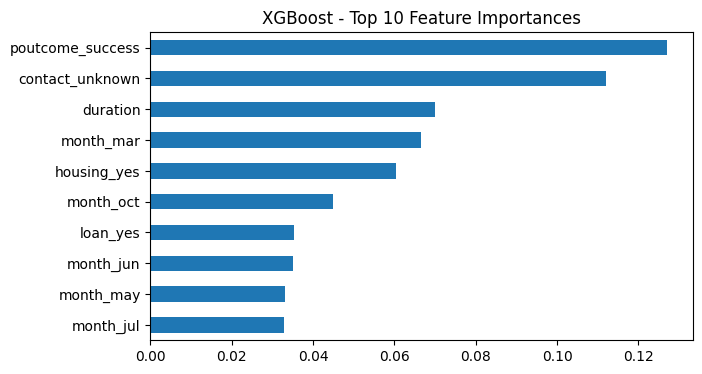

In [19]:
# Feature Importances
xgb_importances = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(7,4))
xgb_importances.head(10).plot(kind='barh')
plt.title("XGBoost - Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [20]:
# 8. Comparison Summary
summary = pd.DataFrame({
    "Model": ["AdaBoost", "XGBoost"],
    "Accuracy": [ada_metrics["accuracy"], xgb_metrics["accuracy"]],
    "Precision": [ada_metrics["precision"], xgb_metrics["precision"]],
    "Recall": [ada_metrics["recall"], xgb_metrics["recall"]],
    "F1-score": [ada_metrics["f1"], xgb_metrics["f1"]],
    "ROC-AUC": [ada_metrics["roc_auc"], xgb_metrics["roc_auc"]]
})
print("\nPerformance Comparison")
print(summary)


Performance Comparison
      Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  AdaBoost  0.841917   0.827907  0.841210  0.834505  0.911487
1   XGBoost  0.863860   0.836007  0.886578  0.860550  0.932001


### 🏁 8. Conclusion

**Performance Comparison**

| Model     | Accuracy | Precision | Recall  | F1-score | ROC-AUC |
|------------|-----------|------------|----------|-----------|-----------|
| AdaBoost  | 0.8419 | 0.8279 | 0.8412 | 0.8345 | 0.9115 |
| XGBoost   | **0.8639** | **0.8360** | **0.8866** | **0.8606** | **0.9320** |

**Interpretation:**  
- **XGBoost** achieved higher accuracy and ROC-AUC, showing better ability to capture complex relationships in the data.  
- **AdaBoost** performed well but was slightly less effective, likely due to its sensitivity to noise and simpler ensemble structure.  
- **XGBoost** also demonstrated stronger recall, indicating better detection of positive cases.

**Conclusion:**  
XGBoost provides superior predictive performance and robustness for the **Bank Marketing dataset**, making it the **recommended model**.  
AdaBoost remains a simpler and more interpretable option but with slightly lower overall results.
